*Note:This version uses a prediction of the error rates in the game depending on the device, the circuit, the order, the lieutenant and his loyalty.*

In [1]:
import numpy as np
from qiskit import QuantumRegister, QuantumCircuit, execute
from qiskit import Aer
from qiskit.providers.aer import AerSimulator

from qiskit.visualization import plot_histogram
import copy, random, itertools
import qiskit.providers.aer.noise as noise
from qiskit.quantum_info.analysis import hellinger_fidelity


In [2]:
# parameters
noise = True
simulator = Aer.get_backend('qasm_simulator')
optimization_level = 2
shots = 8192

verbose_flag = False

# number of generals
N_gen = 3

# here you can change the backends
from qiskit.test.mock import FakeSantiago as device_3_generals

In [3]:
# adapt to given parameters

perms = list(itertools.permutations(['00','01','10'], r=3))
device = device_3_generals

if noise:
    backend = AerSimulator.from_backend(device())
else: # switch to the ideal device
    backend = simulator

In [4]:
# set device dependant parameter for final agreement algorithm
# WIP: this has to be replaced by a more elaborated guess
# from the predicted game-error rates
noise_dic = {'qasm_simulator' : 0.45,
             'aer_simulator(fake_santiago)' : 0.3,
             'aer_simulator(fake_montreal)' : 0.175,
             'aer_simulator(fake_mumbai)' : 0.25,
             'aer_simulator(fake_quito)' : 0.1, 
             'aer_simulator(fake_casablanca)' : 0.15, 
             'aer_simulator(fake_guadalupe)' : 0.1,
             'aer_simulator(fake_sydney)' : 0.15,
            }

In [5]:
# use the simulator to get get the bitstring list
circuit = QuantumCircuit(N_gen+1)
circuit.h(circuit.qubits)

circuit.measure_active()

job = execute(circuit, backend = simulator,shots = 2**13)
              
result = job.result()
counts = result.get_counts(circuit)

bitstrings = np.sort(list(counts.keys()))

#### Prepare the state:


$$ \frac{1}{2\;\sqrt3}\; (\;2\;|0011\rangle - |0101\rangle - |0110\rangle - |1001\rangle -  |1010\rangle + 2\;|1100\rangle\;) $$


In [6]:
init_list = np.array([0., 0., 0., 2., 0., -1., -1., 0.,
             0., -1., -1., 0., 2., 0., 0., 0.]) / ( 2*np.sqrt(3) )

In [7]:
# create the quantum circuit
circuit = QuantumCircuit(N_gen+1)

circuit.initialize(init_list, circuit.qubits)

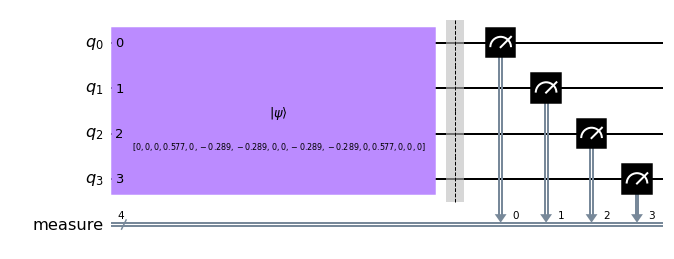

In [8]:
# add Pauli-Z measurements and draw the circuit
circuit.measure_active()
circuit.draw(output='mpl')

In [9]:
# if more details are requested (more .decompose() may be added)
#qasm_circuit = circuit.decompose().decompose() 
#qasm_circuit.draw(output='mpl', fold = 20 - N_gen , plot_barriers=False,
                  #style = {'backgroundcolor': 'cyan'})                                             

## game functions

In [10]:
# byzantine traitor game serving function
# byzantine traitor game serving function
def play(k_list, t_list, n_its_list, used_list, stop_flag, flag_y = None):
    flag_1 = True
    flag_2 = True
    
    retry = True
    while retry:
        k = k_list[-1]
        if k in used_list:
            k_list.pop()
            if k_list == []: 
                stop_flag = True
                return flag_1, flag_2
        else:
            retry = False
            used_list.append(k)
    
    if k in t_list:
        flag_1 = False

    if n_its_list[k] == flag_y: 
        flag_2 = False

    return flag_1, flag_2

In [11]:
def traitor_game(players, verbose = False):
    # start playing
    
    game_rounds = 0
    toss = random.randrange(2)
    head = tail = 0
    gen[players[toss]]['failed'] = 0
    gen[players[1-toss]]['failed'] = 0
    
    mat_t = gen[players[toss]]['mat']
    n_its_toss = n_its[mat_t:mat_t+1][0]
    mat_nt = gen[players[1-toss]]['mat']
    n_its_notoss = n_its[mat_nt:mat_nt+1][0]
    
    flag = np.ones((2, 2), dtype=bool)
    used_list = []
    stop_flag = False
    print("\nByzantine traitor game. First to play is", gen[players[toss]]['name'])
    print("                        Second to play is", gen[players[1-toss]]['name'])    
    
    if verbose:
        print( "shots/2:", shots/2 )
        print(len(gen[players[toss]]['k_list']), "in "  + gen[players[toss]]['name'] + ' list:', 
                   sorted(gen[players[toss]]['k_list']) )   
        print(len(gen[players[1-toss]]['k_list']), "in "  + gen[players[1-toss]]['name'] + ' list:', 
                   sorted(gen[players[1-toss]]['k_list']) )    
    
    while len(gen[players[toss]]['k_list']) > 0 and game_rounds < max_rounds\
            and len(gen[players[1-toss]]['k_list']) > 0 and not stop_flag:
        
        game_rounds += 1        
        
        # first to play
        flag[0][1], flag[1][1] = play(gen[players[toss]]['k_list'],
                                   gen[players[1-toss]]['t_list'],
                                   n_its_notoss, used_list, stop_flag,
                                      gen[players[toss]]['flag_y'])
        
        if not flag[0][1] or not flag[1][1]:                          
            head +=1
        
        gen[players[toss]]['k_list'].pop()

        # second to play
        if not stop_flag: 
            
            flag[0][0], flag[1][0] = play(gen[players[1-toss]]['k_list'],
                                       gen[players[toss]]['t_list'],
                                       n_its_toss, used_list, stop_flag,
                                          gen[players[1-toss]]['flag_y'])

            if not flag[0][0] or not flag[1][0]:                                     
                tail += 1

            gen[players[1-toss]]['k_list'].pop()    
    
    if verbose:
        print(len(used_list), "ind in used_list", sorted(used_list) ) 
    
    print("rounds:", game_rounds)
    
    print(gen[players[1-toss]]['name'] + " counted that " +\
           gen[players[toss]]['name'] + " failed " + str(head)\
           + " times: " + "{:.0%}".format(head / game_rounds))
              
    
    print(gen[players[toss]]['name'] + " counted that " +\
           gen[players[1-toss]]['name'] + " failed " + str(tail)\
           + " times: " + "{:.0%}".format(tail / game_rounds))
    
    return game_rounds, head, tail, toss

## Start experiments
### distribute entaglement

In [12]:
# distribute entanglement 
if noise:
    job_ideal = execute(circuit, backend = simulator, shots = shots,                
                optimization_level = optimization_level)
    
    res_ideal = job_ideal.result()
    counts_ideal = res_ideal.get_counts(circuit)

    if shots <= 200: # for checks
        verbose_flag = True

    job = execute(circuit, backend = backend, shots = shots,
    memory=True,     
    optimization_level = optimization_level)
    
          
    figsize = None

    results = job.result()
    memory = results.get_memory(circuit)
    counts = results.get_counts(circuit)
    legend_to_plot = [simulator, backend.name()]
    counts_to_plot = [counts_ideal,counts]
    print('hellinger fidelity: {:.1%}'.format(
        hellinger_fidelity(counts_ideal,counts)))
else:
    job_ideal = execute(circuit, backend = simulator, shots = shots,
                        memory = True,
                        optimization_level = optimization_level)
    results = job_ideal.result()
    memory = results.get_memory(circuit)
    counts = results.get_counts(circuit)
    legend_to_plot = [backend.name()]
    counts_to_plot = [counts]
    figsize = None

hellinger fidelity: 82.8%


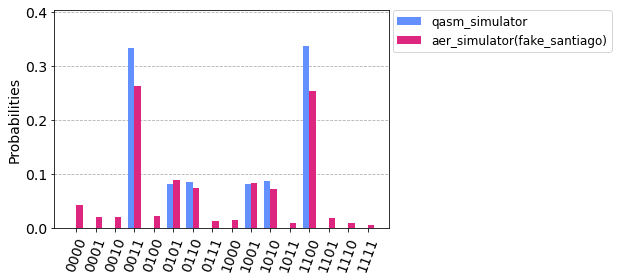

In [13]:
plot_histogram(counts_to_plot, bar_labels = False,
                   figsize = figsize,
                   legend = legend_to_plot)

###   check if the entangled states are not corrupt
 
Mutual verification.

In this version, we simulate this phase and use it for the prediction of game error rates in function of the device, the circuit, the order, the lieutenant, and his loyalty. This can help for traitor discrimination in future version. Here, it is used to determine the optimal lengths of Alice's lists, in order that a traitorous lietenant has the lower probability of success in the game. 

In [14]:
# take a part of the results for check
frac_kept = 3/4 # fraction used for the game
test_i = list(range(shots))
random.shuffle(test_i)
test_i = test_i[:int(shots*(1-frac_kept))]

In [15]:
# get an array for gaming
n_its = np.zeros((N_gen,int(shots*frac_kept))).astype(int)

# convert bitstrings to n_its and store them 

v_dic = {'00': 0, '01': 2,  '10': 2,  '11' : 1, '0' :  0, '1' : 1}

game_i = -1
for j, bitstring in enumerate(memory):
    if j not in test_i:
        game_i += 1
        n_its[0][game_i] = v_dic[bitstring[0:2]] # Alice
        n_its[1][game_i] = v_dic[bitstring[2:3]] # Bob
        n_its[2][game_i] = v_dic[bitstring[3:4]] # Charlie

In [16]:
# game-error prediction on the test fraction

n_success = np.zeros((2, 2, 3))
n_trial = np.zeros((2, 2, 3))

for j, bitstring in enumerate(memory):
    if j in test_i:
        for lieutnt in range(2):             
            for order in range(2):

                # honest lieutenant 
                if bitstring[0:2] == str(order) + str(order):
                    n_trial[lieutnt, order, 0] += 1
                    if bitstring[1-lieutnt+2] == str(1-order):
                        n_success[lieutnt, order, 0] += 1
                # traitor        
                else:
                    if bitstring[lieutnt+2] == str(order):
                        n_trial[lieutnt, order, 1] += 1
                        if bitstring[1-lieutnt+2] == str(order):
                            n_success[lieutnt, order, 1] += 1   

                    elif bitstring[lieutnt+2] == str(1-order):    
                        n_trial[lieutnt, order, 2] += 1                
                        if bitstring[1-lieutnt+2] == str(order):
                            n_success[lieutnt, order, 2] += 1                   

p = n_success/n_trial
q = 1 - p

# determine the optimal lengths of Alice's lists 
n_out = np.zeros((2, 2))
for lieutnt in range(2):
    for order in range(2):
        n_out[lieutnt, order] = n_trial[lieutnt, order, 2] \
          * (p[lieutnt, order, 1] - p[lieutnt, order, 2]) \
          / (q[lieutnt, order, 0] - p[lieutnt, order, 1])
n_out_m = np.round(np.mean(n_out, axis=0)*(frac_kept)/(1-frac_kept)).astype(int)

### use the results to solve the problem

In [17]:
# define faithfulness and tarjet of Alice if she is traitorous: WIP

gen = { 'A': { "mat" : 0, 'name': 'Alice', 'faithful': True, 'target': None},
        'B': { "mat" : 1, 'name': 'Bob', 'faithful': False, 'target': False},
        'C': { "mat" : 2, 'name': 'Charlie', 'faithful': True, 'target': False } }

In [18]:
# check here the number of traitors
 
for key in list(gen.keys())[1:N_gen]:
    if not gen[key]['faithful'] and gen[key]['target']:           
        print("A lieutenant cannot be traitor himself and target of a traitorous commander") 
        print("Please correct the scenario")

traitor_counter = 0
for key in list(gen.keys())[0:N_gen]:    
    if not gen[key]['faithful']:
        traitor_counter += 1

print("Scenario with " + str(N_gen) + " generals and " + str(traitor_counter) + " traitor(s)")

if traitor_counter > N_gen -2 :
    print("No more than " + str(N_gen-2) + " traitor(s) allowed for "\
          + str(N_gen) + " generals, even with quantum power") 
    print("Please correct the scenario")    

Scenario with 3 generals and 1 traitor(s)


In [19]:
# Alice determine the message: 0 for retreat, 1 for attack
m = 0
max_rounds = 500

print("Scenario run on " + backend.name())
print("generals:", list(map(lambda v: v["name"],gen.values()))[0:N_gen])
print("faithful:  ", list(map(lambda v: v["faithful"],gen.values()))[0:N_gen])
print("  target:  ", list(map(lambda v: v["target"],gen.values()))[0:N_gen])

if m == 0:
    print("Order is to retreat")
else :
    print("Order is to attack")

gen['A']['message'] = m
# Alice establishes the corresponding list of indices 
# and the corresponding cheating list

j_list_A = []
j_list_Ac = []
mat = gen['A']['mat']
for k in range(int(shots*frac_kept)):
    val_it = n_its[mat:mat+1][0][k]
    if val_it == m:
        j_list_A.append(k)
    elif val_it == 1 - m:
        j_list_Ac.append(k)

# Alice send her messages and corresponding lists 
# by pairwise authenticated classical and quantum channels  

random.shuffle(j_list_A)
j_list_A = j_list_A[n_out_m[m]:]

random.shuffle(j_list_Ac)
j_list_Ac = j_list_Ac[n_out_m[1-m]:]

j_list_A.sort()
j_list_Ac.sort()

gen['A']['j_list'] = copy.deepcopy(j_list_A) 

for key in list(gen.keys())[1:N_gen]:
    if (not gen['A']['faithful']) and gen[key]['target']:
        gen[key]['message'] = 1 - m    
        gen[key]['j_list'] = copy.deepcopy(j_list_Ac )
    else:
        gen[key]['message'] = m    
        gen[key]['j_list'] = copy.deepcopy(j_list_A) 
            
# test of consistency by the lieutenants (compare j_list and message)
for key in list(gen.keys())[1:N_gen]:
    gen[key]['flag_y'] = gen[key]['message']

# false flag by traitors:
for key in list(gen.keys())[1:N_gen]:
    if gen[key]['faithful']:
        gen[key]['t_list'] = copy.deepcopy(gen[key]['j_list'])
    else:
        gen[key]['flag_y'] = 1 - gen[key]['flag_y']
        gen[key]['t_list'] = list( set(range(int(shots*frac_kept))) - set(gen[key]['j_list']) )

# prepare for treator game

p_list = []
    
for key in list(gen.keys())[1:N_gen]:

    # add to player's list:            
    if gen[key]['flag_y'] != 3: 
        p_list.append(key)

# check if treator game possible
if len(p_list) == 1:
    print("Only one lieutenant has consistent order") 

elif len(p_list) == 0:
    print("No lieutenant has consistent order")
    
else: # treator game:
        
    res_traitor = {}
    
    for players in list(itertools.combinations(p_list, r=2)):
        
        if gen[players[0]]['flag_y'] == gen[players[1]]['flag_y']:
            print("\nNo game between " + gen[players[0]]['name']\
             + " and " + gen[players[1]]['name'] + "\nThey say they got the same order from " + gen['A']['name'])
            res_traitor[players[0] + players[1]] = -1.0
            res_traitor[players[1] + players[0]] = -1.0
        
        else:
            # prepare indices list
                
            for key in players:                  
                mat = gen[key]['mat']

                if gen[key]['faithful']:
                    gen[key]['k_list'] = [] 
                    for k in range(int(shots*frac_kept)):
                        n_it = n_its[mat:mat+1][0][k]

                        if (k in gen[key]['t_list']) and (n_it == 1 - gen[key]['flag_y']):
                            gen[key]['k_list'].append(k)    

                else:
                    gen[key]['k_list'] = copy.deepcopy(gen[key]['t_list'])

                random.shuffle(gen[key]['k_list'])
                      
            game_rounds, head, tail, toss = traitor_game(players, verbose_flag)
            res_traitor[players[1-toss] + players[toss]] = head / game_rounds
            res_traitor[players[toss] + players[1-toss]] = tail / game_rounds    
                
    print("\nFinal agreement:\n")
    
    sorted_res = dict(sorted(res_traitor.items()))
    res_val = list(sorted_res.values())
    test_val = np.round(np.array(res_val) + noise_dic[backend.name()])
    s_test_val = np.sum(test_val)   
    
   
    if s_test_val == - 2:
        print("No traitor detected")
        print("Both lieutenants follow the order of ", gen['A']['name'])

    elif s_test_val == 0:
        print(gen['A']['name'] + " is a traitor")
        print(gen['B']['name'] + " and " + gen['C']['name'] + " agree with a common strategy")        

    elif test_val[0] == [1.] and test_val[1] == [0.]:
        print(gen['C']['name'] + " is a traitor")
        print(gen['B']['name'] + " follows the order of " +  gen['A']['name'])

    elif test_val[0] == [0.] and test_val[1] == [1.]:
        print(gen['B']['name'] + " is a traitor")
        print(gen['C']['name'] + " follows the order of " +  gen['A']['name'])

    else:
        print("Something wrong")

Scenario run on aer_simulator(fake_santiago)
generals: ['Alice', 'Bob', 'Charlie']
faithful:   [True, False, True]
  target:   [None, False, False]
Order is to retreat

Byzantine traitor game. First to play is Charlie
                        Second to play is Bob
rounds: 500
Bob counted that Charlie failed 33 times: 7%
Charlie counted that Bob failed 193 times: 39%

Final agreement:

Bob is a traitor
Charlie follows the order of Alice
